In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="follow_up_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation__follow_up.sample import sample_follow_up_customers
from ml_simulation__follow_up.data import get_follow_up_compute_function
from ml_simulation__follow_up.widget import show_follow_up_widget
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = split_result['simulation']


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

In [6]:
# Sampling
sample_seed = int(time.time() * 1000) % 10000000
selected_ids = sample_follow_up_customers(df_sim, random_state=sample_seed)

Non-converted customers: 923

🎯 SELECTED FOLLOW UP CANDIDATES:
customer_id                          product   price  quote_count
 CL00066986                            Poêle 8325.30            1
 CL00063554                        Chaudière 4155.00            1
 CL00063542                   Photovoltaïque 5542.11            1
 CL00297560 Emetteur de chauffage  ou chappe 1471.46            1
 CL00067051                           Autres 9022.49            1

Selected IDs: ['CL00066986', 'CL00063554', 'CL00063542', 'CL00297560', 'CL00067051']


Initialized Simulation with 5 sampled IDs.


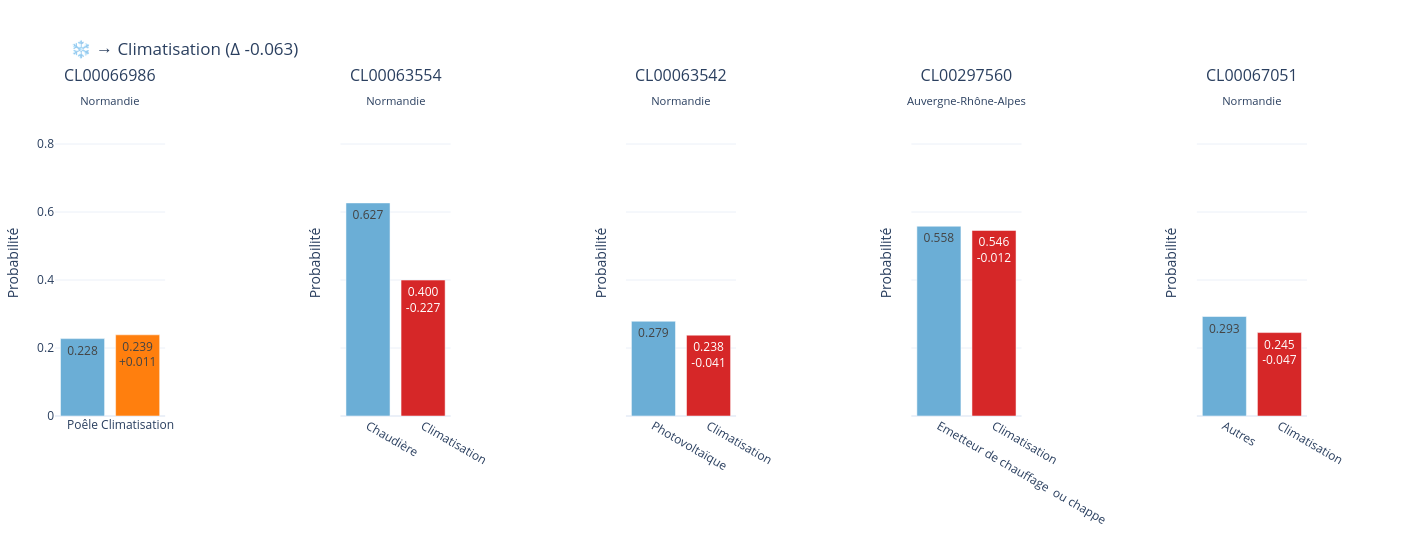

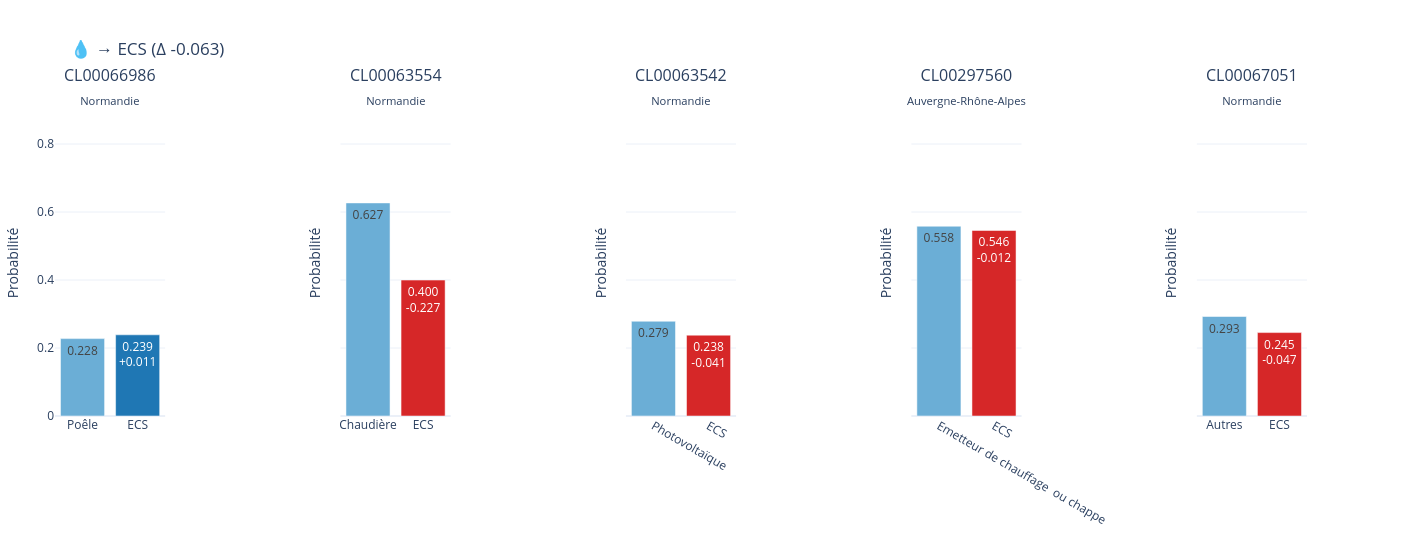

In [7]:
# Simulation
compute = get_follow_up_compute_function(model, feature_names, df_sim, selected_ids)
show_follow_up_widget(compute, selected_ids)